# Modeling Extremes - Empirical

In this example, we will look at how we can use the `scipy` library to learn relevan distributions for extreme values, i.e., GEVD.

In [3]:
import autoroot
import pandas as pd
from scipy.stats import rv_histogram
import numpy as np
import xarray as xr
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [13]:
from bayesevt._src.data.local import DATASET_SPAIN_ANOMALIES

ds = xr.open_mfdataset(DATASET_SPAIN_ANOMALIES["t2max"])

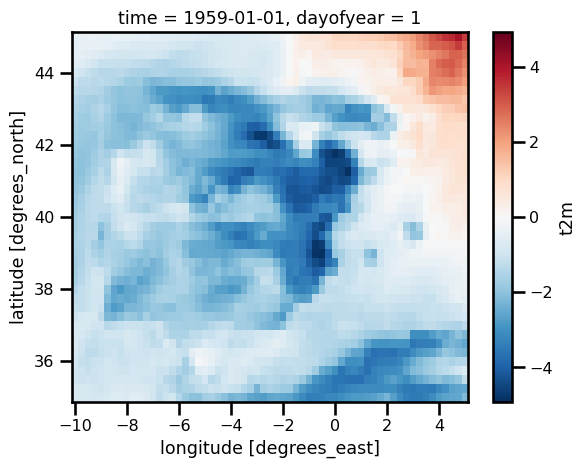

In [14]:
ds.t2m.isel(time=0).plot.pcolormesh()

## Masking

In [15]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask


In [16]:
ds = add_country_mask(ds, country="Spain")
ds = add_land_mask(ds)

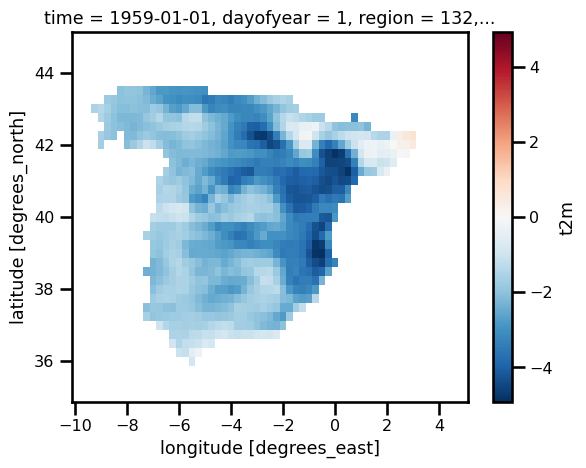

In [17]:

ds.where(ds.spain_mask==1).isel(time=0).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [18]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [19]:
# # take weighted spatial mean
# weights = ds["spain_mask"] * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [20]:

# # convert Kelvin to Celcius
# data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
data.describe()

count    23011.000000
mean        -0.382247
std          3.740105
min        -16.210242
25%         -2.915719
50%         -0.283981
75%          2.215052
max         12.947272
Name: t2m, dtype: float64

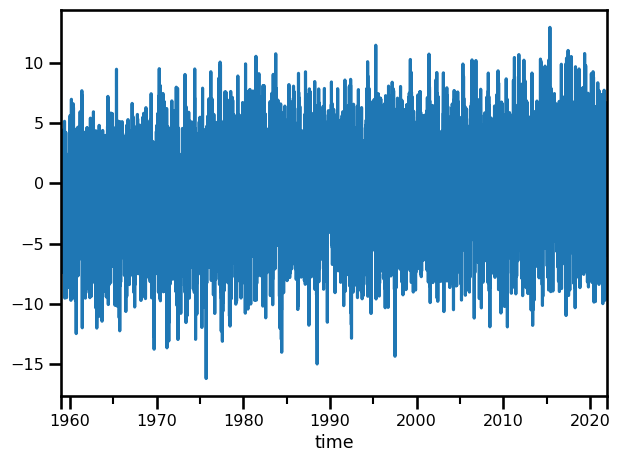

In [21]:
fig, ax = plt.subplots()

data.plot(ax=ax)

plt.tight_layout()
plt.show()

## Extremes

In [22]:
extremes_method = "BM"
block_size = "365.2425D"
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

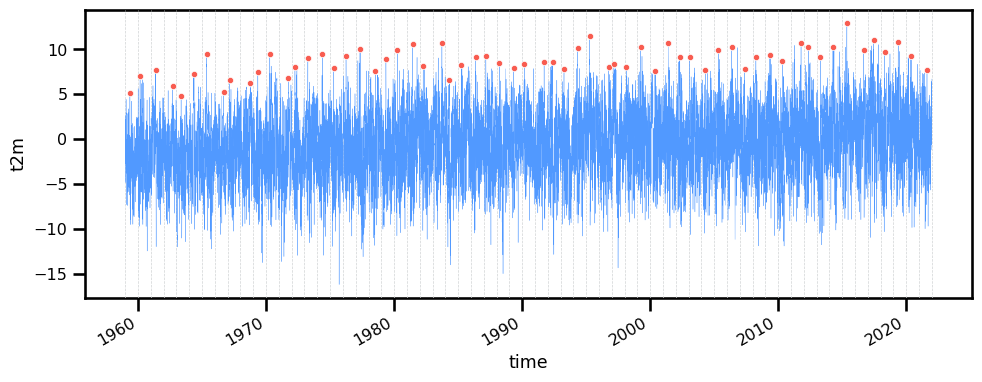

In [23]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

## Model

We will use the GEVD as our model.
The `scipy.stats` library has a `genextreme` distribution which has all of the functionality we need.
It also has built-in method to learn the parameters using the MLE method.

**Resources**:
* Scipy GEV - [scipy docs]()
* Return Values from GEV - [StackOverFlow](https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev)

In [24]:
# fit parameters to data
hist = np.histogram(extremes, bins=30)
model = rv_histogram(hist, density=False)

## Diagnostics: Goodness of Fit

**Null Hypothesis**: *The distribution of the independent samples is identical to the specified cumulative distribution*.

If the statistic is small or the p-value is high, then we accept the null hypothesis.

In [25]:
from scipy.stats import kstest

In [26]:
out = kstest(extremes, model.cdf)
print(f"Kolmogorov-Smirnov Test")
print(f"Statistic: {out.statistic:.4f}")
print(f"P-Value: {out.pvalue:.4f}")

Kolmogorov-Smirnov Test
Statistic: 0.0570
P-Value: 0.9795


We **accept** the null hypothesis.

### Viz I: CDF

In [27]:
# create a length of the domain
x_domain = np.linspace(extremes.min(), extremes.max(), 100)
# get the PDF of the distribution
y_pdf = model.pdf(x_domain)

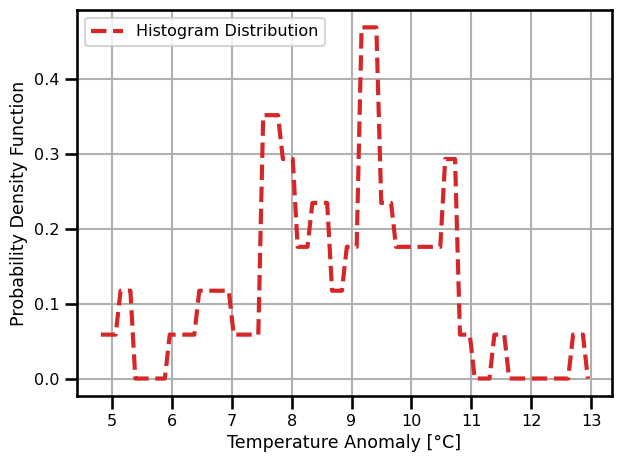

In [29]:
fig, ax = plt.subplots()

ax.plot(x_domain, y_pdf, linewidth=3, linestyle="--", color="tab:red", label="Histogram Distribution")

ax.set(
    xlabel="Temperature Anomaly [°C]",
    ylabel="Probability Density Function",
)

plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

### Viz II: PDF

In [30]:
# get the CDF of the distribution
y_cdf = model.cdf(x_domain)

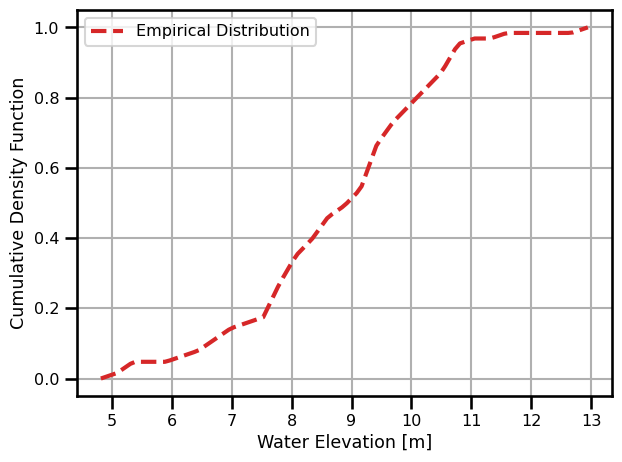

In [31]:
fig, ax = plt.subplots()

ax.plot(x_domain, y_cdf, linewidth=3, linestyle="--", color="tab:red", label="Empirical Distribution")

ax.set(
    xlabel="Water Elevation [m]",
    ylabel="Cumulative Density Function",
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

## Return Period

A major goal of the EVT is to estimate the extreme values corresponding to some return periods.
In other words, we want to know the relationship between the non-exceedence probability and the return periods.
This relationship is given by:

$$
p(X\leq x_T) = \frac{1}{T}
$$

where $x_T$ is the extreme annual water elevation corresponding to the return period of $T$.

**Resources**:
* Return Values from GEV - [StackOverFlow](https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev)

In [38]:
# simple return periods
return_periods = np.logspace(-0.999, 2, 100)
# calculate
return_levels = model.isf(1/return_periods)

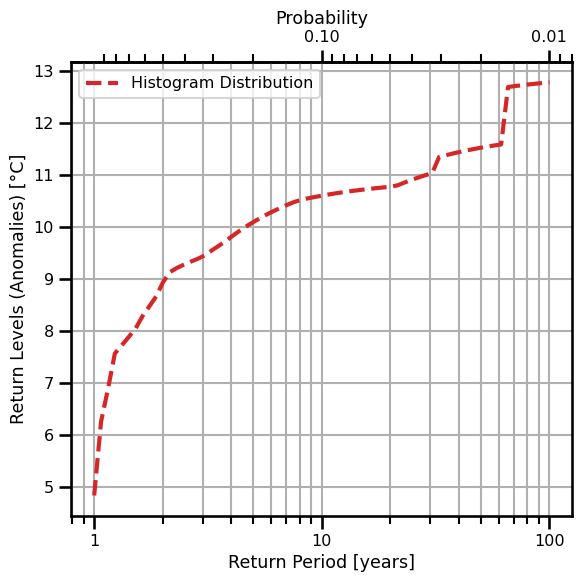

In [39]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    return_periods, return_levels, 
    linestyle="--", linewidth=3, color="tab:red",
    label="Histogram Distribution",
)


ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels (Anomalies) [°C]",
    xscale="log",
)

# SECOND AXIS
def safe_reciprocal(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x, float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = np.reciprocal(x[~near_zero])
    return x

secax = ax.secondary_xaxis("top", functions=(safe_reciprocal, safe_reciprocal))
secax.set_xlabel("Probability")
secax.set_xticks([0.1, 0.01])

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
secax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()
